In [1]:
import pandas as pd

ruta_base = 'Dades/'
ruta_archivo = ruta_base + 'dataset_combinado_final.parquet'  

df = pd.read_parquet(ruta_archivo)
df = df.drop(columns=['longitude', 'latitude', 'time'])
df = df.dropna(subset=['LATITUD_G', 'LONGITUD_G'])
df.sort_values(by=['FECHA', 'LATITUD_G', 'LONGITUD_G'], inplace=True)


Estación 0: Punto Origen POINT (-607073.0506767619 4319382.637095876)
Estación 0, Cercano 2: Punto Destino POINT (-605867.4605914707 4322893.9143974)
Estación 0, Cercano 4: Punto Destino POINT (-604773.1899969728 4324686.52548267)
Estación 0, Cercano 5: Punto Destino POINT (-610123.2047244976 4324780.3010159405)
Estación 0, Cercano 11: Punto Destino POINT (-605106.0352744447 4326862.879210296)
Estación 0, Cercano 8: Punto Destino POINT (-602395.4056736286 4325707.067698079)
Estación 0, Cercano 9: Punto Destino POINT (-611024.8925999231 4326192.54864089)
Estación 0, Cercano 7: Punto Destino POINT (-599177.1591947951 4325431.235971992)
Estación 0, Cercano 6: Punto Destino POINT (-598561.5624107082 4325338.83391839)
Estación 0, Cercano 10: Punto Destino POINT (-598989.0292553543 4326273.924001994)
Estación 0, Cercano 15: Punto Destino POINT (-604494.8912699897 4329837.110835947)
Estación 1: Punto Origen POINT (-595376.7117791126 4322572.654750649)
Estación 1, Cercano 3: Punto Destino POIN

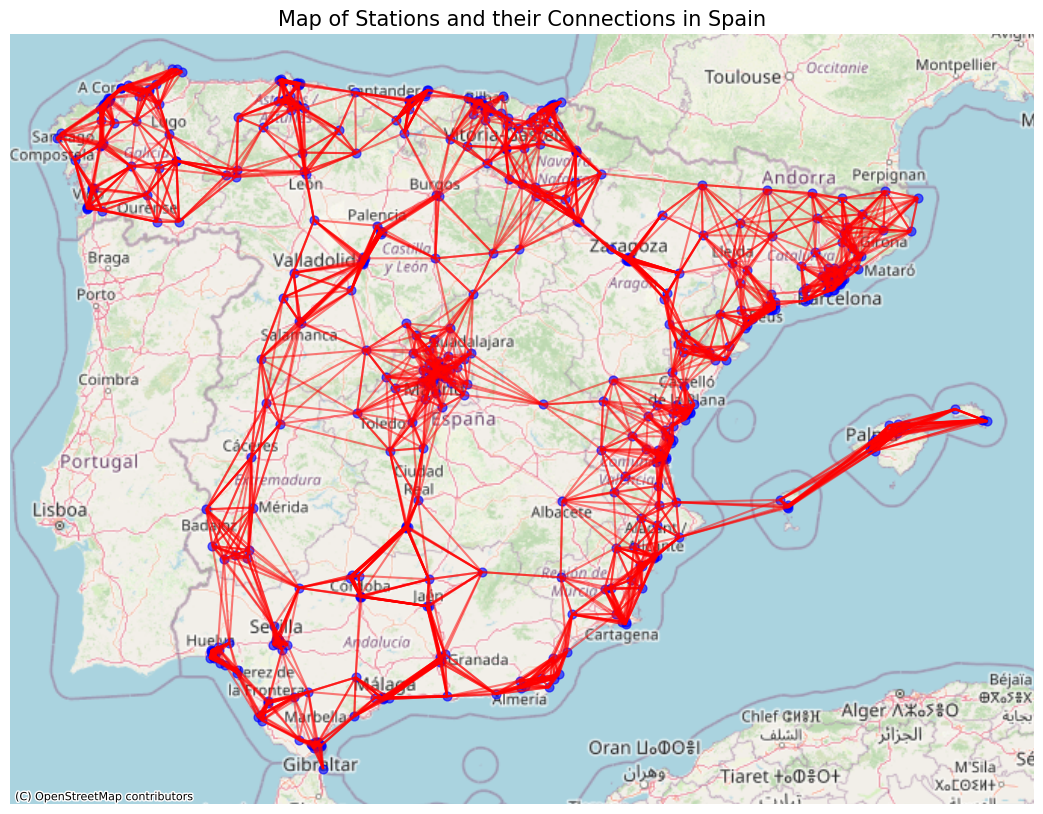

In [2]:
import numpy as np
from itertools import combinations
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import contextily as ctx

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distancia_horizontal = R * c
    return distancia_horizontal

def distancia_con_altitud(lat1, lon1, alt1, lat2, lon2, alt2):
    distancia_horizontal = haversine(lat1, lon1, lat2, lon2)
    diferencia_altitud = abs(alt1 - alt2) / 1000  
    distancia_total = np.sqrt(distancia_horizontal**2 + diferencia_altitud**2)
    return distancia_total


columnas = ['Estacion1', 'Estacion2', 'Distancia']
distancias_df = pd.DataFrame(columns=columnas)
estaciones_unicas = df[['LATITUD_G', 'LONGITUD_G', 'ALTITUD']].drop_duplicates()
estaciones_unicas = estaciones_unicas.reset_index(drop=True)
distancias_df = pd.DataFrame(columns=['Estacion1', 'Estacion2', 'Distancia'])

for (idx1, row1), (idx2, row2) in combinations(estaciones_unicas.iterrows(), 2):
    distancia = distancia_con_altitud(row1['LATITUD_G'], row1['LONGITUD_G'], row1['ALTITUD'],
                                      row2['LATITUD_G'], row2['LONGITUD_G'], row2['ALTITUD'])
    nueva_fila = pd.DataFrame({'Estacion1': [idx1], 'Estacion2': [idx2], 'Distancia': [distancia]})
    distancias_df = pd.concat([distancias_df, nueva_fila], ignore_index=True)


cuatro_mas_cercanas_df = pd.DataFrame(index=estaciones_unicas.index, columns=['Cercano1', 'Cercano2', 'Cercano3', 'Cercano4', 'Cercano5', 'Cercano6', 'Cercano7', 'Cercano8', 'Cercano9', 'Cercano10'])

for estacion in estaciones_unicas.index:
    distancias_estacion = distancias_df[(distancias_df['Estacion1'] == estacion) | (distancias_df['Estacion2'] == estacion)]
    distancias_ordenadas = distancias_estacion.sort_values(by='Distancia').head(10)
    cercanas = distancias_ordenadas.apply(lambda x: x['Estacion2'] if x['Estacion1'] == estacion else x['Estacion1'], axis=1)
    cuatro_mas_cercanas_df.loc[estacion] = list(cercanas)

gdf_estaciones = gpd.GeoDataFrame(estaciones_unicas, geometry=gpd.points_from_xy(estaciones_unicas.LONGITUD_G, estaciones_unicas.LATITUD_G))

gdf_estaciones.set_crs(epsg=4326, inplace=True)
gdf_estaciones = gdf_estaciones.to_crs(epsg=3857)
lineas = []

for estacion in gdf_estaciones.index:
    punto_origen = gdf_estaciones.loc[estacion, 'geometry']
    print(f"Estación {estacion}: Punto Origen {punto_origen}")  

    for cercano in cuatro_mas_cercanas_df.loc[estacion]:
        if pd.notna(cercano):
            punto_destino = gdf_estaciones.loc[cercano, 'geometry']
            print(f"Estación {estacion}, Cercano {cercano}: Punto Destino {punto_destino}")  
            try:
                lineas.append(LineString([punto_origen, punto_destino]))
            except IndexError as e:
                print(f"Error al crear LineString entre estación {estacion} y cercano {cercano}: {e}")


gdf_lineas = gpd.GeoDataFrame(geometry=lineas, crs=gdf_estaciones.crs)

fig, ax = plt.subplots(figsize=(15, 10))

gdf_estaciones.plot(ax=ax, color='blue', alpha=0.6, markersize=40)
gdf_lineas.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Map of Stations and their Connections in Spain', fontsize=15)
ax.set_axis_off()

plt.show()



In [3]:
import torch
from torch_geometric.data import Data

nodos = estaciones_unicas.shape[0]
edge_index = []
edge_attr = []
added_edges = set()

for idx, estacion in estaciones_unicas.iterrows():
    for cercano_idx in cuatro_mas_cercanas_df.loc[idx]:
        if pd.notna(cercano_idx):
            cercano_idx = int(cercano_idx)

            if (idx, cercano_idx) not in added_edges and (cercano_idx, idx) not in added_edges:
                estacion_cercana = estaciones_unicas.iloc[cercano_idx]
                edge_index.append([idx, cercano_idx])
                added_edges.add((idx, cercano_idx))
                distancia = distancia_con_altitud(
                    estacion['LATITUD_G'], estacion['LONGITUD_G'], estacion['ALTITUD'],
                    estacion_cercana['LATITUD_G'], estacion_cercana['LONGITUD_G'], estacion_cercana['ALTITUD']
                )
                edge_attr.append([distancia])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)
x = torch.zeros((nodos, 1))
grafo_base = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [4]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df.set_index('FECHA', inplace=True)

In [5]:
print(df.columns)

Index(['C6H6', 'CO', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25', 'SO2',
       'LATITUD_G', 'LONGITUD_G', 'ALTITUD', 'TIPO_ESTACION_FONDO',
       'TIPO_ESTACION_INDUSTRIAL', 'TIPO_ESTACION_TRAFICO', 'TIPO_AREA_RURAL',
       'TIPO_AREA_SUBURBANA', 'TIPO_AREA_URBANA', 'ZONA_AGRICOLA',
       'ZONA_AGRICOLA/NATURALEZA', 'ZONA_COMERCIAL/INDUSTRIAL',
       'ZONA_COMERCIAL/INDUSTRIAL/AGRICOLA', 'ZONA_COMERCIAL/NATURALEZA',
       'ZONA_DESCONOCIDO', 'ZONA_INDUSTRIAL', 'ZONA_INDUSTRIAL/AGRICOLA',
       'ZONA_INDUSTRIAL/NATURALEZA', 'ZONA_MAR(CERCA)', 'ZONA_MONTAÑA',
       'ZONA_NATURALEZA', 'ZONA_PARQUE', 'ZONA_RESIDENCIAL',
       'ZONA_RESIDENCIAL/AGRICOLA', 'ZONA_RESIDENCIAL/AGRICOLA/NATURALEZA',
       'ZONA_RESIDENCIAL/COMERCIAL', 'ZONA_RESIDENCIAL/COMERCIAL/INDUSTRIAL',
       'ZONA_RESIDENCIAL/COMERCIAL/NATURALEZA', 'ZONA_RESIDENCIAL/INDUSTRIAL',
       'ZONA_RESIDENCIAL/INDUSTRIAL/AGRICOLA',
       'ZONA_RESIDENCIAL/INDUSTRIAL/NATURALEZA', 'ZONA_RESIDENCIAL/NATURALEZA',
       't2m

In [6]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data


df_resampled = df.groupby(['LATITUD_G', 'LONGITUD_G', pd.Grouper(freq='2h')]).mean().reset_index()
df_resampled.set_index('FECHA', inplace=True)
columnas_objetivo = ['C6H6', 'CO', 'NO2', 'NOx', 'O3', 'PM10', 'PM25', 'SO2']
caracteristicas = [col for col in df_resampled.columns if col not in ['LATITUD_G', 'LONGITUD_G']]
total_intervalos = len(pd.date_range(start=df_resampled.index.min(), end=df_resampled.index.max(), freq='2h'))
intervalos_procesados = 0
snapshots = []

for fecha in pd.date_range(start=df_resampled.index.min() + pd.Timedelta(hours=12), end=df_resampled.index.max() - pd.Timedelta(hours=12), freq='2h'):
    datos_x = []
    datos_y = []
    print(f"Procesando intervalo {intervalos_procesados} de {total_intervalos}: {fecha}")
    for (lat, lon), grupo in df_resampled.groupby(['LATITUD_G', 'LONGITUD_G']):
        historico_x = []
        for h in range(2, 14, 2):  
            momento_historico = fecha - pd.Timedelta(hours=h)
            mediciones_historicas = grupo.loc[grupo.index == momento_historico, caracteristicas]
            if not mediciones_historicas.empty:
                historico_x.extend(mediciones_historicas.astype(float).to_numpy()[0])
            else:
                historico_x.extend(np.zeros(len(caracteristicas)))
        datos_x.append(historico_x)
        futuro_y = []
        for h in range(2, 14, 2):  
            momento_futuro = fecha + pd.Timedelta(hours=h)
            mediciones_futuras = grupo.loc[grupo.index == momento_futuro, columnas_objetivo]
            if not mediciones_futuras.empty:
                if mediciones_futuras.isnull().values.any():
                    mediciones_imputadas = mediciones_futuras.fillna(method='bfill').fillna(0)
                    futuro_y.extend(mediciones_imputadas.mean().to_numpy())
                else:
                    futuro_y.extend(mediciones_futuras.mean().to_numpy())
            else:
                futuro_y.extend(np.zeros(len(columnas_objetivo)))

        datos_y.append(futuro_y)

    intervalos_procesados += 1
    x = torch.tensor(np.array(datos_x, dtype=np.float32), dtype=torch.float)
    y = torch.tensor(np.array(datos_y, dtype=np.float32), dtype=torch.float)
    snapshot = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    snapshots.append(snapshot)

print("Proceso completado.")

Procesando intervalo 0 de 21912: 2018-01-01 12:00:00
Procesando intervalo 1 de 21912: 2018-01-01 14:00:00
Procesando intervalo 2 de 21912: 2018-01-01 16:00:00
Procesando intervalo 3 de 21912: 2018-01-01 18:00:00
Procesando intervalo 4 de 21912: 2018-01-01 20:00:00
Procesando intervalo 5 de 21912: 2018-01-01 22:00:00
Procesando intervalo 6 de 21912: 2018-01-02 00:00:00
Procesando intervalo 7 de 21912: 2018-01-02 02:00:00
Procesando intervalo 8 de 21912: 2018-01-02 04:00:00
Procesando intervalo 9 de 21912: 2018-01-02 06:00:00
Procesando intervalo 10 de 21912: 2018-01-02 08:00:00
Procesando intervalo 11 de 21912: 2018-01-02 10:00:00
Procesando intervalo 12 de 21912: 2018-01-02 12:00:00
Procesando intervalo 13 de 21912: 2018-01-02 14:00:00
Procesando intervalo 14 de 21912: 2018-01-02 16:00:00
Procesando intervalo 15 de 21912: 2018-01-02 18:00:00
Procesando intervalo 16 de 21912: 2018-01-02 20:00:00
Procesando intervalo 17 de 21912: 2018-01-02 22:00:00
Procesando intervalo 18 de 21912: 2018

In [7]:
len(snapshots)

21900

In [8]:
for i, snapshot in enumerate(snapshots):
    print(f"Snapshot {i}:")
    print(f"  - Dimensiones de x: {snapshot.x.size()}")
    print(f"  - Dimensiones de y: {snapshot.y.size()}")
    num_no_ceros = torch.count_nonzero(snapshot.y).item()
    total_elementos = torch.numel(snapshot.y)
    porcentaje_no_ceros = (num_no_ceros / total_elementos) * 100

    print(f"  - Número de valores no cero en y: {num_no_ceros} de {total_elementos} ({porcentaje_no_ceros:.2f}%)")
    if i >= 2: 
        break

Snapshot 0:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21597 de 24576 (87.88%)
Snapshot 1:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21627 de 24576 (88.00%)
Snapshot 2:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21634 de 24576 (88.03%)


In [9]:
import os
import dill
import numpy as np
import torch
from torch_geometric.data import Data

ruta_guardado = "Dades/Snapshots"

os.makedirs(ruta_guardado, exist_ok=True)
for i, snapshot in enumerate(snapshots):
    ruta_archivo = os.path.join(ruta_guardado, f'snapshot_{i}.pkl')
    snapshot_dict = {
        'edge_index': snapshot.edge_index.cpu().numpy(),
        'x': snapshot.x.cpu().numpy(),
        'edge_attr': snapshot.edge_attr.cpu().numpy(),
        'y': snapshot.y.cpu().numpy(),
    }
    
    with open(ruta_archivo, 'wb') as f:
        dill.dump(snapshot_dict, f)
print("Todos los snapshots han sido guardados.")


Todos los snapshots han sido guardados.


In [10]:
import torch
for i, snapshot in enumerate(snapshots):
    nan_indices = torch.isnan(snapshot.x)
    if nan_indices.any():
        print(f"Valores nan encontrados en x del snapshot {i}")
        print("Valores de x con NaN:", snapshot.x[nan_indices])

In [11]:
for i, snapshot in enumerate(snapshots):
    if torch.isnan(snapshot.x).any():
        print(f"Valores nan encontrados en x del snapshot {i}")
    if torch.isnan(snapshot.y).any():
        print(f"Valores nan encontrados en y del snapshot {i}")

In [12]:
snapshot = snapshots[0].x
print("Primeras filas de x:", snapshot[:5])
print("Últimas filas de x:", snapshot[-5:])
print("Alguna fila específica:", snapshot[10])  

Primeras filas de x: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.7965e-01, 7.4500e-01, 2.0000e+00,  ..., 1.0205e+05, 0.0000e+00,
         0.0000e+00],
        [1.5401e+00, 2.8870e-01, 3.7000e+01,  ..., 1.0219e+05, 0.0000e+00,
         0.0000e+00],
        [5.6721e-01, 3.6635e-01, 1.0000e+01,  ..., 1.0205e+05, 0.0000e+00,
         0.0000e+00],
        [1.0043e+00, 4.5833e-01, 1.8000e+01,  ..., 1.0219e+05, 0.0000e+00,
         0.0000e+00]])
Últimas filas de x: tensor([[0.0000e+00, 3.6000e-01, 1.5000e+00,  ..., 1.0019e+05, 0.0000e+00,
         0.0000e+00],
        [3.4676e-01, 2.9000e-01, 1.0000e+00,  ..., 1.0019e+05, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0411e-01, 2.6603e-01, 6.9272e+00,  ..., 1.0106e+05, 0.0000e+00,
         1.3579e-06],
        [7.0950e-01, 2.7373e-01, 8.0000e-01,  ..., 1.0106e+05, 0.0000e+00,
         1

In [13]:
for i, snapshot in enumerate(snapshots):
    print(f"Snapshot {i}:")
    print(f"  - Dimensiones de x: {snapshot.x.size()}")
    print(f"  - Dimensiones de y: {snapshot.y.size()}")
    num_no_ceros = torch.count_nonzero(snapshot.y).item()
    total_elementos = torch.numel(snapshot.y)
    porcentaje_no_ceros = (num_no_ceros / total_elementos) * 100
    print(f"  - Número de valores no cero en y: {num_no_ceros} de {total_elementos} ({porcentaje_no_ceros:.2f}%)")
    if i >= 15:  
        break

Snapshot 0:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21597 de 24576 (87.88%)
Snapshot 1:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21627 de 24576 (88.00%)
Snapshot 2:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21634 de 24576 (88.03%)
Snapshot 3:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21645 de 24576 (88.07%)
Snapshot 4:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21657 de 24576 (88.12%)
Snapshot 5:
  - Dimensiones de x: torch.Size([512, 270])
  - Dimensiones de y: torch.Size([512, 48])
  - Número de valores no cero en y: 21648 de 24576 (88.09%)
Snapshot 6:
  - Dimensiones de x: 